# Revisiting the 2 Dimensional Fourier Transform 
## Improving Cars as a Proxy for Shoppers

<img width=60% src=pics/new_parking_lot.jpg /img>
source of image: http://www.fanrto.com/upload/4/a3/4a372e17716046f6.jpg

We know that there are companies which use satellite images of parking lots, to quantify the 
amount of shoppers at a given client business. Using a deep neural network to analyze 30 cm resolution satelite images, the number of cars in the 
parking lot can be accurately counted.

Counting cars is a great first step to quantification, but how about getting closer to actual buying power and conversion ratio ?

$$total\text{ }shoppers \approx \left(\frac{people}{1{car}}\right)(n_{cars})$$

## Purpose of this exercise
For this notebook, I'm going to use the above parking lot satelite image to practice analysising a 2D FFT. 

1. No need to classify / tag anything
2. Good practice in remembering how K-space works
3. Another reason to use Python for image processing
4. Practice using an imperfect method to derive business insights

# Fundalmental Business Question
* How can we better estimate the spending power represented by a vehilce ?

## Heuristics That Seem Reasonable
 * Assume that more people means tendency to higher expenditure
 * Bigger vehicles have the ability to transport more or larger items
 * Larger size vehicles bring more shoppers

### Experiment
* Take an image of vertically alinged cars in a parking lot.
* Count the number of cars to simulate the ML classifier's automated count.
* Perform 2D FFT 
  * Detect vehicle sizes with resolution of 1 meter
  * use ratio of signal to total car count to estimate number of vehicles with size $x$
* Try to generalize to any orientation of vehicle in a parking lot.

### Set up Python

In [308]:
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt
from scipy import fftpack
import radialProfile
%matplotlib inline
import sys
sys.path.append("/home/daniel/git/Python2.7/DataScience/notebooks/orbital")

data = scipy.ndimage.imread("pics/new_parking_lot.jpg", flatten=False)

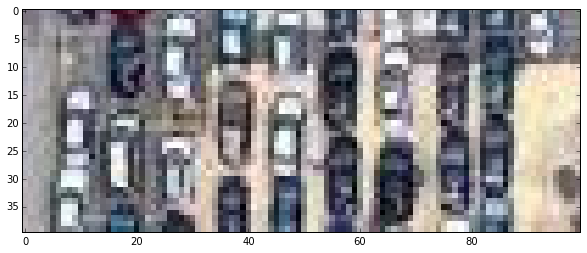

In [309]:
data_sub = data[50:90, 0:100]
plt.figure(figsize=(10, 10))
plt.imshow(data_sub, interpolation='nearest', origin='upper')

# Estimate the sample image resolution
Another heuristic:

* vehicle widths have less variation across size class than lengths
 * I'll use the width to estimate the image resolution


I counted the numebr of pixels that appear to make up a car width and figured that the average car is
$\approx 185 cm$ in width.

$$res = \frac{185 cm}{6_{pixels}} \approx 31 cm $$

<b>Let's call it 30 cm which I know to be a standard image product dimension used by analysis companies.</b>

Zoom in enough to count pixels to width. I count 6 pixels for a vehicle width.

# Technical Considerations
For simplicity sake:
* I'm only using the length dimension which is the y axis in my images
* Using an image sub section with veritcally aligned cars

## Some vehicle lengths
I didn't spend very much time to accurately determine the average dimensions of vehicles by class.
That's another project in itself. For this notebook I think it will suffice to choose reasonable test dimensions.

<table>
<hd><tr><td>Model</td><td>Length</td><td>Schematic</td></tr></hd>
<tr><td>Chevy Tahoe</td><td>$513 cm$</td><td><img width=60% src=pics/tahoe_dim.jpg /img></td>
<tr><td>Toyata Celica</td><td>$450 cm$</td> <td><img width=60% src=pics/celica_dim.jpg /img></td>
<tr><td>$\Delta{L}$</td><td>$63cm$</td><td></td></tr>
</table>



$k_{nyquist}$ for 30 cm camera = 60 cm. 

We should be able to detect the difference in length (y axis in our test image).

In [310]:
# reload the data in grey scale mode
data = scipy.ndimage.imread("pics/new_parking_lot.jpg", flatten=True)
data_sub = data[50:90, 0:100]

In [311]:
def fft2D(data, zoom=1):
    zoom = np.floor(zoom).astype(int)
    fft = fftpack.fft2(data)
    fft  = fftpack.fftshift(fft)
    power2D = fft.real**2
    half = power2D.shape[0]/2
    if zoom == 1:
        power1D = power2D[:, 0:half].mean(0) 
    else:
        out = power2D[:, 0:half]
        out = scipy.signal.decimate(out, zoom, axis=0)
        out = scipy.signal.decimate(out, zoom, axis=1)
        power1D = out.mean(1)
            
    power1D *=  0.5 * 1.0/data.shape[0]
    return power1D

In [312]:
## k space scale
def k_scale(dim, npts, zoom=1.0):
    zoom = np.floor(zoom).astype(np.int16)
    camera_res = 0.30/zoom # m          
    max_len = camera_res * dim #m , size of sub plot
    nyq = 2 * camera_res #m
    range_ = max_len - nyq
    # reverse order
    k = np.flipud(np.arange(nyq, max_len,range_/npts))
    return k

In [336]:
zoom = 7
data_sub_hires = scipy.ndimage.zoom(data_sub, zoom=zoom, order=3, mode='nearest', prefilter=True)
data_sub_hires = scipy.ndimage.filters.gaussian_filter(data_sub_hires, 5)

data_sub_hires = scipy.signal.decimate(data_sub_hires, zoom, axis=0)
data_sub_hires = scipy.signal.decimate(data_sub_hires, zoom, axis=1)

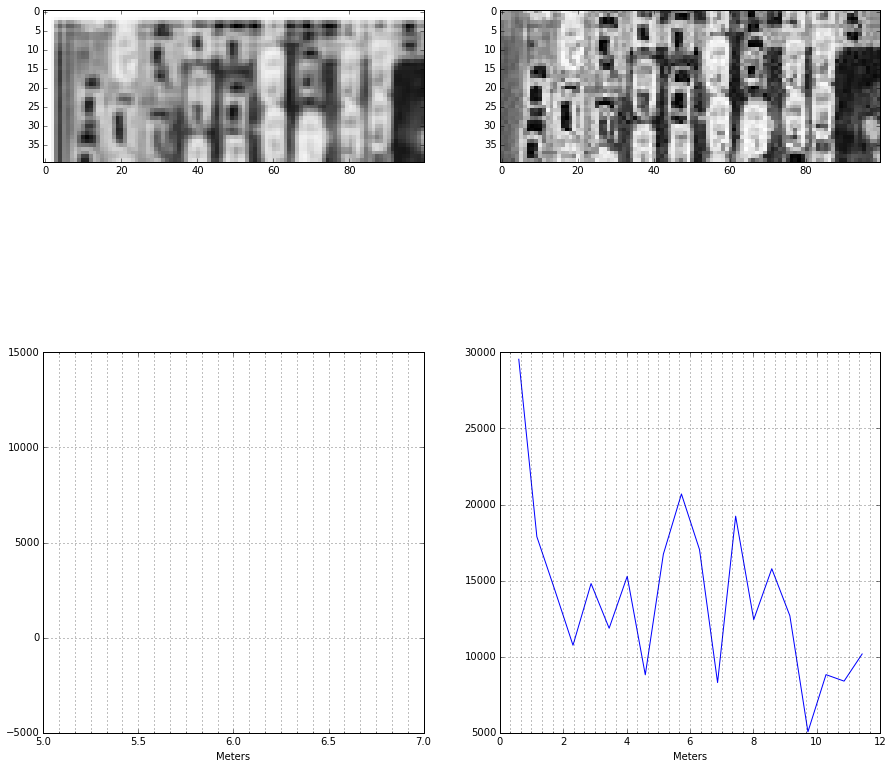

In [337]:
from matplotlib.ticker import AutoMinorLocator

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(data_sub_hires, interpolation='nearest', origin='upper', cmap='Greys')

plt.subplot(222)
plt.imshow(data_sub, interpolation='nearest', origin='upper', cmap='Greys')

power1D = fft2D(data_sub_hires, zoom=4)
k = k_scale(data_sub_hires.shape[0], power1D.shape[0], zoom=4)

ax223 = plt.subplot(223)
plt.plot(k, power1D)
plt.xlim(5, 7)
minor_locator = AutoMinorLocator(6)
ax223.xaxis.set_minor_locator(minor_locator)
plt.xlabel("Meters")
plt.grid(which='both')

power1D = fft2D(data_sub)
k = k_scale(data_sub.shape[0], power1D.shape[0], zoom=1)

ax224 = plt.subplot(224)
plt.plot(k[:], power1D)
minor_locator = AutoMinorLocator(6)
ax224.xaxis.set_minor_locator(minor_locator)
plt.xlabel("Meters")
plt.grid(which='both')

Try again with an edge filter first.

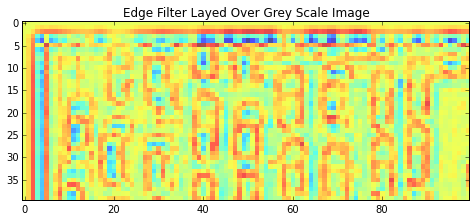

In [353]:
sobel = scipy.ndimage.filters.laplace(data_sub_hires)
sobel[np.isnan(sobel)] = 0

plt.figure(figsize=(8, 8))
plt.imshow(sobel, interpolation='nearest', origin='upper', cmap='jet', alpha=0.7)
#plt.imshow(data_sub_hires, interpolation='nearest', origin='upper', cmap='gray', alpha=0.4)
plt.title("Edge Filter Layed Over Grey Scale Image")

I'm hoping that the roughly 1.2, 2.25 and 3.1 meter peaks are cars and that means we can classify vehicles by size.

(4.5, 7.5)

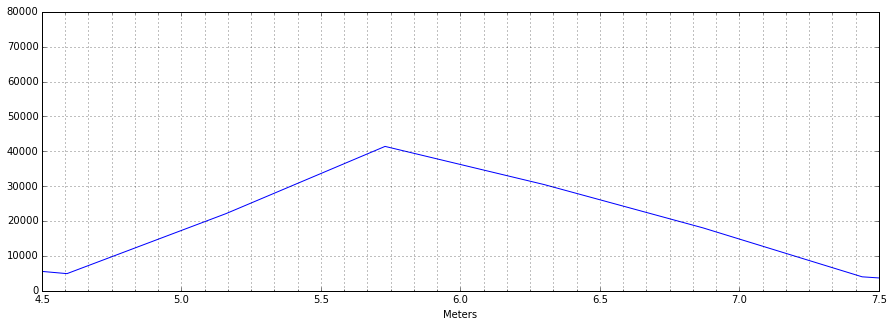

In [352]:
zoom = 1
power1D_sobel = fft2D(sobel, zoom=zoom)
k_sobel = k_scale(sobel.shape[0], power1D_sobel.shape[0], zoom=zoom)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)
plt.plot(k_sobel[:], power1D_sobel)
minor_locator = AutoMinorLocator(6)
ax.xaxis.set_minor_locator(minor_locator)
plt.xlabel("Meters")

plt.grid(which='both')
plt.xlim(4.5, 7.5)

In [317]:
band_3m = np.where((k > 5.0) & (k <= 7.0))[0]

In [318]:
total = power1D_sobel.sum()

In [319]:
power1D[band_3m].sum() / total 

7336.6839259698882

In [320]:
zoom = 7
data = scipy.ndimage.imread("pics/new_parking_lot.jpg", flatten=True)
data = scipy.ndimage.zoom(data, zoom=zoom, order=3, mode='nearest', prefilter=True)
data = scipy.ndimage.filters.gaussian_filter(data, 3)

data -= data.mean()
data -= data.min()
data /= data.max()


data[data >= 0.30] = 0
data[data > 0] = 1
#data = scipy.ndimage.filters.laplace(data)
#data[np.isnan(data)] = 0

<matplotlib.colorbar.Colorbar instance at 0x7ff9ab718950>

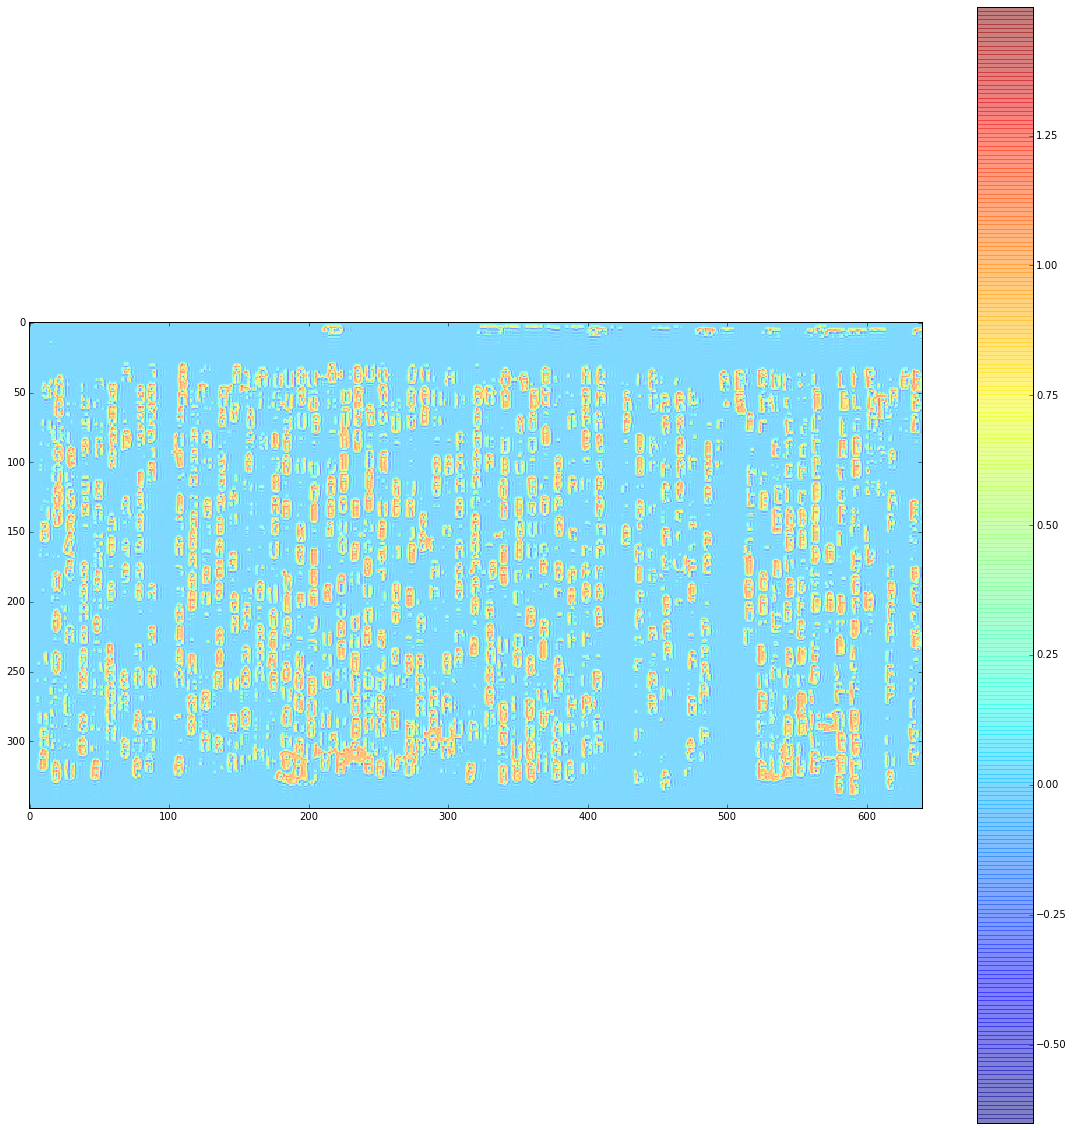

In [321]:
plt.figure(figsize=(20, 20))

data = scipy.signal.decimate(data, zoom, axis=0)
data = scipy.signal.decimate(data, zoom, axis=1)


plt.imshow(data, interpolation='nearest', origin='upper', cmap='jet', alpha=0.5)
plt.colorbar()

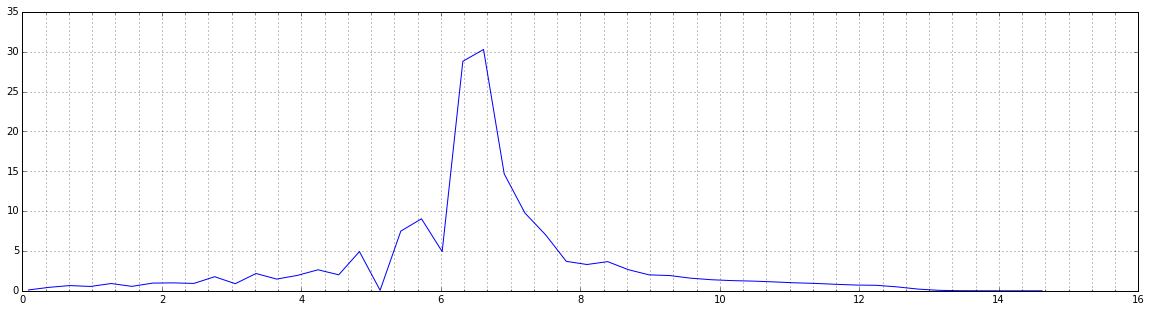

In [322]:
power1D_edge = fft2D(data, zoom=zoom)
k_edge = k_scale(data.shape[0], power1D_edge.shape[0], zoom=zoom)

plt.figure(figsize=(20, 5))

ax = plt.subplot(111)
plt.plot(k_edge, power1D_edge)
minor_locator = AutoMinorLocator(6)
ax.xaxis.set_minor_locator(minor_locator)

plt.grid(which='both')
#plt.xlim(4.5, 7.5)